<a href="https://colab.research.google.com/github/DEP04929/ESICMDatathon2024/blob/main/AKI_20240615.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites for Amsterdam UMC DB


In [564]:
# sets *your* project id
PROJECT_ID = "esicmdatathon2024" #@param {type:"string"}


In [565]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [566]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')


Authenticated


In [567]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 200
DataTable.max_rows = 30000


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [568]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config


In [569]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns
sns.set_style('darkgrid')

In [570]:

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

# Get list of patients for AKI

## Part 1/2 get AKI patients

In [571]:
%%bigquery AKI --project $PROJECT_ID
-- Combined SQL query to filter data initially and load into Pandas
WITH included_patients AS (
  SELECT person_id, visit_occurrence_id
  FROM visit_occurrence
  WHERE DATE_DIFF(visit_end_datetime, visit_start_datetime, hour)/24.0 >= 2
),
-- count measurements of creatinine > 1
patients_with_creatinine AS (
  SELECT person_id, visit_occurrence_id
  FROM measurement
  WHERE measurement_concept_id = 3020564 -- Creatinine
    AND provider_id IS NOT NULL
    AND visit_occurrence_id IN (
        SELECT visit_occurrence_id FROM included_patients
    )
  GROUP BY person_id, visit_occurrence_id
  HAVING COUNT(measurement_id) > 1
),
-- creatinine value > 400 before first visit
excluded_high_creatinine AS (
  SELECT DISTINCT visit_occurrence_id
  FROM measurement
  WHERE measurement_concept_id = 3020564 -- Creatinine
    AND provider_id IS NOT NULL
    AND measurement_datetime < (SELECT MIN(visit_start_datetime)
                            FROM visit_occurrence
                            WHERE visit_occurrence_id = measurement.visit_occurrence_id)
    AND value_as_number > 400
),
-- Exclude kidney transplant persons regardless of timestamp of procedure
excluded_nephrectomy_kidney_transplant AS (
  SELECT DISTINCT visit_occurrence_id
  FROM procedure_occurrence
  WHERE procedure_concept_id IN (4146256, 4021108, 4022014, 4322471) -- Nephrectomy and Kidney Transplant
  AND provider_id IS NOT NULL
),
-- Exclude rrt before first admission by visit
excluded_rrt_before_admission AS (
  SELECT DISTINCT p.visit_occurrence_id
  FROM procedure_occurrence p
  inner join visit_occurrence v
  on v.visit_occurrence_id = p.visit_occurrence_id
  WHERE p.procedure_concept_id = 4051330 -- RRT
    AND p.provider_id IS NOT NULL
    AND p.procedure_datetime < visit_start_datetime
),
-- exclude too little count of creatinine before the first RRT by person not by visit
excluded_few_creatinine_before_rrt AS (
  SELECT visit_occurrence_id
  FROM (
      SELECT visit_occurrence_id, COUNT(measurement_id) AS creatinine_measurement_count
      FROM measurement m
      WHERE measurement_concept_id = 3020564 --Creatinine
        AND provider_id IS NOT NULL
        AND measurement_datetime < (SELECT MIN(procedure_datetime)
                                FROM procedure_occurrence p
                                WHERE procedure_concept_id = 4051330 -- RRT
                                  AND provider_id IS NOT NULL
                                  AND p.visit_occurrence_id = m.visit_occurrence_id)
      GROUP BY m.visit_occurrence_id
  ) AS subquery
  WHERE creatinine_measurement_count <= 1
),

-- this gives the set of included persons
final_patients AS (
  SELECT person_id, visit_occurrence_id
  FROM patients_with_creatinine
  WHERE visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_high_creatinine)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_nephrectomy_kidney_transplant)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_rrt_before_admission)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_few_creatinine_before_rrt)
),

first_scr AS (
  SELECT
    m.person_id
    , m.visit_occurrence_id
    , m.value_as_number AS first_scr
  FROM
    measurement m
  JOIN
    visit_occurrence v ON m.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    m.measurement_concept_id = 3020564 -- Creatinine
    AND m.provider_id IS NOT NULL
    AND m.measurement_datetime BETWEEN timestamp_add(v.visit_start_datetime, INTERVAL -365 day)
                               AND timestamp_add(v.visit_start_datetime, INTERVAL 7 day)
    AND m.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
  QUALIFY
    ROW_NUMBER() OVER (PARTITION BY m.person_id, m.visit_occurrence_id
          -- this is to find the baseline scr nearest to the visit start datetime :
           ORDER BY abs(timestamp_diff(m.measurement_datetime, visit_start_datetime, minute)) asc ) = 1
),
-- need highest creatinine during stay for determining AKI later steps
aki_patients AS (
  SELECT m.visit_occurrence_id,
    max(m.value_as_number) AS highest_scr,
  FROM measurement m
  inner JOIN
    first_scr l ON m.visit_occurrence_id = l.visit_occurrence_id
  inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    m.measurement_concept_id = 3020564 -- creatinine
    AND m.provider_id IS NOT NULL
    AND m.measurement_datetime between v.visit_start_datetime and v.visit_end_datetime
    AND m.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
  group by m.visit_occurrence_id, l.first_scr
),

-- finds RRT procedures after admission
rrt_initiation AS (
  SELECT
    p.person_id,
    p.visit_occurrence_id,
    min(p.procedure_datetime) as procedure_datetime,
    -- time from admission to start of RRT procedure
    date_diff( min(p.procedure_datetime), v.visit_start_datetime, minute)/60.0 as admit_to_rrt_hours
  FROM
    procedure_occurrence p
    inner join visit_occurrence v on p.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    procedure_concept_id IN (4051330) -- RRT procedures
    AND procedure_datetime >= visit_start_datetime
    AND p.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
    AND p.provider_id IS NOT NULL
  group by person_id, visit_occurrence_id, visit_start_datetime
)

SELECT
  fp.person_id,
  fp.visit_occurrence_id,
  fs.first_scr,
  ak.highest_scr, --ak.scr_aki,
  case when rrt.procedure_datetime is not null then 1 else 0 end as rrt_procedure_after_admit,
  rrt.procedure_datetime AS rrt_start_date,
  rrt.admit_to_rrt_hours as admit_to_rrt_hours
FROM
  final_patients fp
left join
  first_scr fs on fp.visit_occurrence_id = fs.visit_occurrence_id
LEFT JOIN
  aki_patients ak ON fp.visit_occurrence_id = ak.visit_occurrence_id
LEFT JOIN
  rrt_initiation rrt ON fp.visit_occurrence_id = rrt.visit_occurrence_id;


Query is running:   0%|          |

Downloading:   0%|          |

In [572]:
s = AKI.select_dtypes(include='object').columns
AKI[s] = AKI[s].astype("float")


In [573]:
AKI.describe()

,person_id,visit_occurrence_id,first_scr,highest_scr,rrt_procedure_after_admit,admit_to_rrt_hours
count,7908.0,7908.0,7899.000000,7898.000000,7908.0,693.000000
mean,10191.585989,11804.347876,103.329662,138.269435,0.087633,94.082949
std,5842.813298,6773.250533,67.085880,111.402535,0.282778,205.560974
min,4.0,4.0,4.000000,4.000000,0.0,1.466667
25%,5163.25,5960.0,67.000000,74.000000,0.0,24.016667
50%,10215.5,11837.5,88.000000,100.000000,0.0,45.933333
75%,15233.25,17642.75,117.000000,163.000000,0.0,82.250000
max,20322.0,23548.0,2157.000000,3187.000000,1.0,3458.333333


In [574]:
# It is not correct here to fill NaN yet.
# AKI['admit_to_rrt_hours'].fillna(0, inplace=True)

In [575]:
AKI.describe()

,person_id,visit_occurrence_id,first_scr,highest_scr,rrt_procedure_after_admit,admit_to_rrt_hours
count,7908.0,7908.0,7899.000000,7898.000000,7908.0,693.000000
mean,10191.585989,11804.347876,103.329662,138.269435,0.087633,94.082949
std,5842.813298,6773.250533,67.085880,111.402535,0.282778,205.560974
min,4.0,4.0,4.000000,4.000000,0.0,1.466667
25%,5163.25,5960.0,67.000000,74.000000,0.0,24.016667
50%,10215.5,11837.5,88.000000,100.000000,0.0,45.933333
75%,15233.25,17642.75,117.000000,163.000000,0.0,82.250000
max,20322.0,23548.0,2157.000000,3187.000000,1.0,3458.333333


<Axes: xlabel='admit_to_rrt_hours', ylabel='Count'>

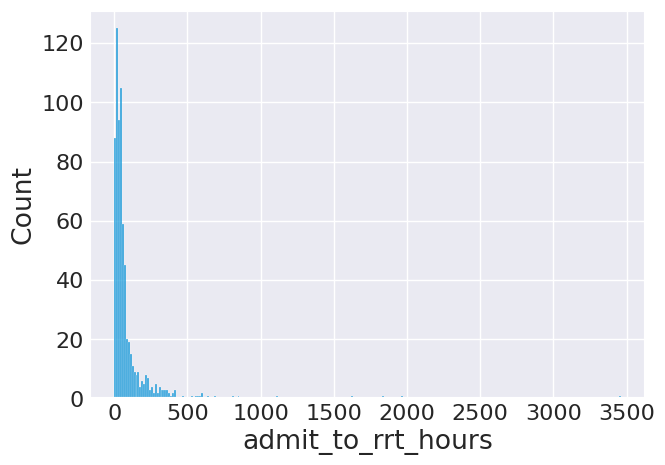

In [576]:
sns.histplot(AKI['admit_to_rrt_hours'])

## Part 2/2 Urine output per weight



### Weight and urine output

I took heart rate to figure out if the patient is actually at the bedside. Only the first 7 days (7*24 hours from admission) of patient stay is considered.

In [577]:
%%bigquery urine_roll_avg --project $PROJECT_ID
with bd_wght as (
SELECT m.visit_occurrence_id, m.value_as_number as body_weight
  FROM measurement m
  WHERE measurement_concept_id in (3026600, 3013762, 3023166, 3025315) -- Body Weight
    AND m.provider_id IS NULL
) ,
-- using the heart rate to determine if a person is at the bedside, gets all hours of stay of a person
-- use "distinct" to remove duplicate entries
hr_hours as (
  select distinct m.person_id, m.visit_occurrence_id,  DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from visit_occurrence v
  inner join measurement m  on m.visit_occurrence_id = v.visit_occurrence_id
  where m.provider_id is not null
    and m.measurement_concept_id = 21490872 -- Heart rate.beat-to-beat by EKG
    and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
    and m.measurement_datetime between v.visit_start_datetime
              and timestamp_add (visit_start_datetime, Interval 7*24 hour)
  -- and m.person_id = 12  -- random test
),
-- get all urine output charted. round the measurement time to the nearest hour
-- use "distinct" to remove duplicate entries
urine_hours as (
  select distinct m.person_id, m.visit_occurrence_id, m.value_as_number , m.measurement_datetime
    , DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from measurement m
  inner join visit_occurrence v
  on m.visit_occurrence_id = v.visit_occurrence_id
  and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
  where m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
    and m.provider_id is not null
    and m.measurement_datetime between v.visit_start_datetime and timestamp_add (visit_start_datetime, Interval 7*24 hour)
    and m.value_as_number > 1 -- to avoid possible entries of 0 for "UrineIncontinentie"
  --  and m.person_id = 12 -- test only, random
) ,
-- fill all rows where there is a heart rate but no urine output as zero urine for the hour
urine_fillnull as(
select h.*, ifnull(u.value_as_number,0) as urine_hour
from hr_hours h left outer join urine_hours u
on h.visit_occurrence_id = u.visit_occurrence_id
and h.rounded_to_hour = u.rounded_to_hour
),
-- calculate 6 hour and 12 hour rolling averages
roll_avg as (
select person_id, visit_occurrence_id, rounded_to_hour
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 24 preceding and current row) as avg_24_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 12 preceding and current row) as avg_12_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 6 preceding and current row) as avg_6_roll_urine
from urine_fillnull
)
select a.person_id, a.visit_occurrence_id, w.body_weight
, avg(avg_24_roll_urine/w.body_weight) AS rolling_mean_24h_mL_kg_h
, avg(avg_12_roll_urine/w.body_weight) AS rolling_mean_12h_mL_kg_h
, avg(avg_6_roll_urine/w.body_weight) AS rolling_mean_6h_mL_kg_h
from roll_avg a inner join bd_wght w
on a.visit_occurrence_id = w.visit_occurrence_id
group by a.person_id, a.visit_occurrence_id, w.body_weight


Query is running:   0%|          |

Downloading:   0%|          |

In [578]:
s = urine_roll_avg.select_dtypes(include='object').columns
urine_roll_avg[s] = urine_roll_avg[s].astype("float")

In [579]:
urine_roll_avg.describe()

,person_id,visit_occurrence_id,body_weight,rolling_mean_24h_mL_kg_h,rolling_mean_12h_mL_kg_h,rolling_mean_6h_mL_kg_h
count,8002.0,8002.0,8002.000000,8002.000000,8002.000000,8002.000000
mean,10177.788428,11788.356036,79.416396,1.259647,1.276600,1.283817
std,5846.371362,6777.360001,14.914348,0.717110,0.712436,0.711867
min,4.0,4.0,55.000000,0.000000,0.000000,0.000000
25%,5144.75,5937.75,65.000000,0.830253,0.847975,0.855823
50%,10198.5,11812.5,75.000000,1.194915,1.214110,1.227744
75%,15230.0,17635.75,85.000000,1.592840,1.621471,1.629881
max,20322.0,23548.0,115.000000,11.160936,8.767864,7.533652


<Axes: xlabel='rolling_mean_6h_mL_kg_h', ylabel='Count'>

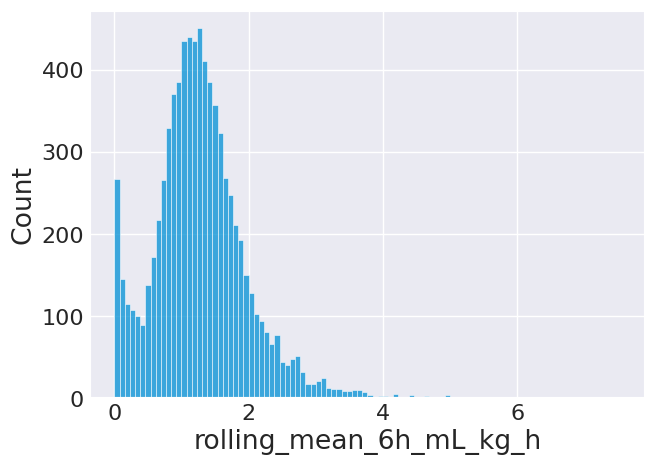

In [580]:
sns.histplot(urine_roll_avg['rolling_mean_6h_mL_kg_h'])

## merge AKI with Urine output

In [581]:
cols_to_use = urine_roll_avg.columns.difference(AKI.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(AKI, urine_roll_avg[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')


Clean up to save space

In [582]:
del AKI, urine_roll_avg

In [583]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   person_id                  7908 non-null   Int64              
 1   visit_occurrence_id        7908 non-null   Int64              
 2   first_scr                  7899 non-null   float64            
 3   highest_scr                7898 non-null   float64            
 4   rrt_procedure_after_admit  7908 non-null   Int64              
 5   rrt_start_date             693 non-null    datetime64[us, UTC]
 6   admit_to_rrt_hours         693 non-null    float64            
 7   body_weight                7666 non-null   float64            
 8   rolling_mean_12h_mL_kg_h   7666 non-null   float64            
 9   rolling_mean_24h_mL_kg_h   7666 non-null   float64            
 10  rolling_mean_6h_mL_kg_h    7666 non-null   float64            
dtypes: I

## Extra conditions for KDIGO

In [584]:

condition_1_mask = (
    (df['rolling_mean_12h_mL_kg_h'] == 0) |
    (df['rolling_mean_24h_mL_kg_h'] < 0.3) |
    (df['highest_scr'] >= df['first_scr'] * 3.0) |
    ((df['highest_scr'] - df['first_scr']) >= 353.6) |
    (df['rrt_start_date'].notnull())
)

condition_2_mask = (
    ~condition_1_mask & (
        ((df['highest_scr'] >= df['first_scr'] * 2.0) & (df['highest_scr'] < df['first_scr'] * 3.0)) |
        (df['rolling_mean_12h_mL_kg_h'] < 0.5)
    )
)

condition_3_mask = (
    ~condition_1_mask & ~condition_2_mask & (
        (df['rolling_mean_6h_mL_kg_h'] < 0.5) |
        ((df['highest_scr'] >= df['first_scr'] * 1.5) & (df['highest_scr'] < df['first_scr'] * 2.0)) |
        ((df['highest_scr'] - df['first_scr']) >= 26.5)
    )
)

df['worst_KDIGO'] = np.select(
    [condition_1_mask, condition_2_mask, condition_3_mask],
    [3, 2, 1],
    default=0
)


<Axes: xlabel='worst_KDIGO', ylabel='Count'>

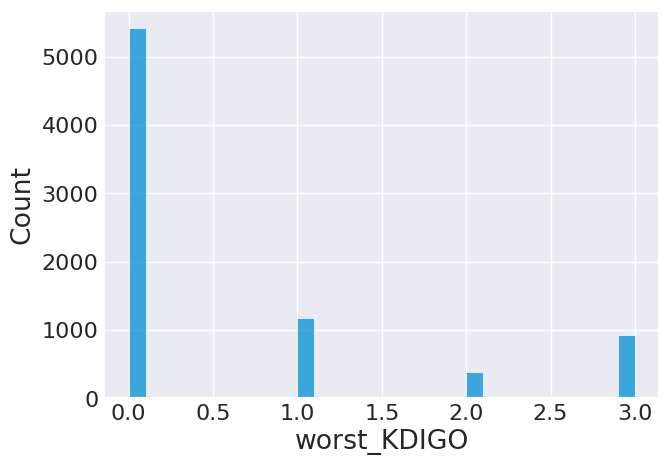

In [585]:
sns.histplot(df['worst_KDIGO'])

### delete those that have no urine output
1. delete those have no baseline creatinine and no highest creatinine
2. delete those that have no rolling 6h urine output

If urine values and body are missing, i think we should drop them. Something would have been wrong with the recording on this case and makes it irrelevant for our learning.  

In [586]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values

rrt_start_date               7215
admit_to_rrt_hours           7215
body_weight                   242
rolling_mean_12h_mL_kg_h      242
rolling_mean_24h_mL_kg_h      242
rolling_mean_6h_mL_kg_h       242
highest_scr                    10
first_scr                       9
person_id                       0
visit_occurrence_id             0
rrt_procedure_after_admit       0
worst_KDIGO                     0
dtype: int64

In [587]:
df = df[df['rolling_mean_6h_mL_kg_h'].notna()]
df = df[df['first_scr'].notna()]
df = df[df['highest_scr'].notna()]

## Remove columns irrelevant to learning

In [588]:
cols_to_keep = [ 'person_id', 'visit_occurrence_id','first_scr', 'highest_scr', 'admit_to_rrt_hours', 'worst_KDIGO'
                , 'rolling_mean_6h_mL_kg_h', 'rolling_mean_12h_mL_kg_h', 'rolling_mean_24h_mL_kg_h']

df = df.loc[: ,cols_to_keep]


In [589]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values


admit_to_rrt_hours          7008
person_id                      0
visit_occurrence_id            0
first_scr                      0
highest_scr                    0
worst_KDIGO                    0
rolling_mean_6h_mL_kg_h        0
rolling_mean_12h_mL_kg_h       0
rolling_mean_24h_mL_kg_h       0
dtype: int64

# Other parameters for clustering

## demographics


In [590]:
%%bigquery demographics_df --project $PROJECT_ID
WITH Demographics AS (
    SELECT
        vo.person_id,
        vo.visit_occurrence_id,
        EXTRACT(YEAR FROM CURRENT_DATE) - p.year_of_birth AS age,
        CASE WHEN p.gender_concept_id = 8507 THEN 1 -- Male
             WHEN p.gender_concept_id = 8532 THEN 2 -- Female
             ELSE 0 -- Other or unknown
             END AS sex
    FROM
        visit_occurrence vo
    LEFT JOIN
        person p ON vo.person_id = p.person_id
),

HeightMeasurements AS (
    SELECT
        m.person_id,
        CAST(AVG(m.value_as_number) AS FLOAT64) AS avg_height
    FROM
        measurement m
    WHERE
        m.measurement_concept_id IN (3035463, 3023540, 3019171, 3036277) -- height
        AND provider_id IS NULL
        AND m.visit_occurrence_id IS NOT NULL  -- Ensure measurement is linked to a visit
    GROUP BY
        m.person_id
),

WeightMeasurements AS (
    SELECT
        m.person_id,
        CAST(AVG(m.value_as_number) AS FLOAT64) AS avg_weight
    FROM
        measurement m
    WHERE
        m.measurement_concept_id IN (3026600, 3013762, 3023166, 3025315) -- weight
        AND provider_id IS NULL
        AND m.visit_occurrence_id IS NOT NULL  -- Ensure measurement is linked to a visit
    GROUP BY
        m.person_id
)

SELECT
    d.person_id,
    d.visit_occurrence_id,
    d.age,
    d.sex,
    h.avg_height AS height,
    w.avg_weight AS weight,
    CAST(w.avg_weight / (h.avg_height / 100) / (h.avg_height / 100) AS FLOAT64) AS bmi
FROM
    Demographics d
LEFT JOIN
    HeightMeasurements h ON d.person_id = h.person_id
LEFT JOIN
    WeightMeasurements w ON d.person_id = w.person_id


Query is running:   0%|          |

Downloading:   0%|          |

In [591]:
cols_to_use = demographics_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, demographics_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del demographics_df

## Reason for admission

In [592]:
%%bigquery reasons_df --project $PROJECT_ID
with r as (
SELECT
  visit_occurrence_id, min(concept_name) as concept_name, 1 as val
FROM
  observation o
  inner join concept c
  on o.value_as_concept_id = c.concept_id
WHERE
  observation_concept_id = 37154585
  AND provider_id IS NOT NULL
group by visit_occurrence_id
)
select * from r
PIVOT ( max(val) for concept_name in ('Emergency', 'Patient Died Before Therapy', 'Scheduled surgical procedure', 'Emergency surgery'))


Query is running:   0%|          |

Downloading:   0%|          |

In [593]:
cols_to_use = reasons_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, reasons_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del reasons_df

In [594]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

In [595]:
df[cols_to_use] = df[cols_to_use].fillna(0)

## Conditions, procedures

In [596]:
%%bigquery septic_df --project $PROJECT_ID
SELECT distinct
  visit_occurrence_id,
  1 AS sepsis
FROM
  condition_occurrence o
  inner join concept c on o.condition_concept_id =c.concept_id
WHERE
  condition_concept_id IN (132797, 44820254, 44827180, 1572267, 37394658)
  AND provider_id IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [597]:
cols_to_use = septic_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, septic_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del septic_df

In [598]:
df['sepsis'] = df['sepsis'].fillna(0)

In [599]:
%%bigquery procedures_df --project $PROJECT_ID
with p as (
SELECT distinct
  visit_occurrence_id,
  case when procedure_concept_id = 4148948 then 'Vascular_surgery'
       when procedure_concept_id in (4299602, 4080799) then 'Gastrointestinal_surgery'
       when procedure_concept_id in (4301351, 4159949) then 'General_surgery'
       when procedure_concept_id in (4012185, 4042641) then 'Cardiovascular_surgery'
      end as type_name ,
  1 AS present
FROM
  procedure_occurrence p
  inner join concept c on procedure_concept_id = concept_id
WHERE
  procedure_concept_id IN (
        4148948, -- Vascular_surgery
        4299602, 4080799, -- Gastrointestinal_surgery
        4301351, 4159949, -- General_surgery
        4012185, 4042641 -- Cardiovascular_surgery
  )
  AND provider_id IS NOT NULL
)
select * from p
PIVOT (max(present) for type_name in ('Vascular_surgery', 'Gastrointestinal_surgery', 'General_surgery', 'Cardiovascular_surgery' )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [600]:
cols_to_use = procedures_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, procedures_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del procedures_df

In [601]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
df[cols_to_use] = df[cols_to_use].fillna(0)

## Previous Comorbidities?

In [602]:
%%bigquery previous_comorbidities_df --project $PROJECT_ID
SELECT
    co.visit_occurrence_id,
    MAX(CASE WHEN co.condition_concept_id = 201254 THEN 1 ELSE 0 END) AS is_type_1_diabetes,
    MAX(CASE WHEN co.condition_concept_id = 316866 AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_hypertension,
    MAX(CASE WHEN co.condition_concept_id IN (37016181, 317576) THEN 1 ELSE 0 END) AS is_coronary_artery_disease,
    MAX(CASE WHEN co.condition_concept_id IN (312723, 319835, 321588, 4281749) AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_heart_disease,
    MAX(CASE WHEN co.condition_concept_id IN (45769564, 4245975) AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_heart_failure,
    MAX(CASE WHEN co.condition_concept_id IN (199744, 4116087, 37168850, 443568, 197230, 439404, 80665, 258369, 318096, 198985, 40493428, 35610239, 35610164, 4313916, 196653, 443397, 25189, 443398, 443387, 197508, 4180793, 4178968, 4181345, 4147164, 4112853, 4169598, 4181343, 4044013) THEN 1 ELSE 0 END) AS is_cancer
FROM
    condition_occurrence co
JOIN
    visit_occurrence vo ON co.visit_occurrence_id = vo.visit_occurrence_id
WHERE
    co.condition_concept_id IN (201254, 316866, 37016181, 317576, 312723, 319835, 321588, 4281749, 45769564, 4245975, 199744, 4116087, 37168850, 443568, 197230, 439404, 80665, 258369, 318096, 198985, 40493428, 35610239, 35610164, 4313916, 196653, 443397, 25189, 443398, 443387, 197508, 4180793, 4178968, 4181345, 4147164, 4112853, 4169598, 4181343, 4044013)
GROUP BY
    co.visit_occurrence_id;


Query is running:   0%|          |

Downloading:   0%|          |

In [603]:
cols_to_use = previous_comorbidities_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, previous_comorbidities_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del previous_comorbidities_df

In [604]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
df[cols_to_use] = df[cols_to_use].fillna(0)

## Hemoglobin A1c

Here there are very few values.
Leave out.

In [605]:
%%bigquery hemoglobin --project $PROJECT_ID
SELECT
    m.visit_occurrence_id
    , approx_quantiles(value_as_number, 100)[offset(50)] as median_HgA1c
FROM
    measurement m inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
WHERE
    m.measurement_concept_id = 3004410 -- Hg1Ac
    AND m.provider_id IS NOT NULL
group by m.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [606]:
# cols_to_use = hemoglobin.columns.difference(df.columns)
# cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
# df = pd.merge(df, hemoglobin[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del hemoglobin

## MAP

In [607]:
%%bigquery MAP --project $PROJECT_ID
SELECT
    m.visit_occurrence_id
    , approx_quantiles(value_as_number, 100)[offset(50)] as median_MAP
FROM
    measurement m inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
WHERE
    m.measurement_concept_id in (21492241, 21490852) -- mean art press from NIBP or ABP
    AND m.provider_id IS NOT NULL
group by m.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [608]:
cols_to_use = MAP.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, MAP[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del MAP

## Ventilator

In [609]:
%%bigquery vent_pat --project $PROJECT_ID
with tracheal as (
select d.person_id, d.visit_occurrence_id
, min(device_exposure_start_datetime) as insert_trach
, timestamp_diff(min(device_exposure_start_datetime), visit_start_datetime, hour)/24.0 as days_admit_to_first_trach
  from device_exposure d
inner join concept c2 on d.device_concept_id= c2.concept_id
inner join visit_occurrence v on d.visit_occurrence_id = v.visit_occurrence_id
          and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour )/24.0 >= 2 -- filter for longer patients only
where NOT d.provider_id IS NULL -- ignore unvalidated device data
  and c2.concept_id in ( 45772284 -- Tracheostomy tube speech valve
                        ,4097216 -- Endotracheal tube
                        ,4044008 -- Tracheostomy tube
                        ,4208623 -- Double lumen tracheobronchial tube
        )
group by d.person_id, d.visit_occurrence_id, visit_start_datetime
),
vent_pat as (
select m.person_id, m.visit_occurrence_id
      , count(distinct m.measurement_date ) as days_vent -- based on parameters, estimate duration days
      , min(measurement_datetime) as first_date_vent
      , timestamp_diff(min(measurement_datetime), visit_start_datetime, HOUR)/24.0 as days_admit_to_first_vent
  from measurement m
inner join concept c2 on m.measurement_concept_id= c2.concept_id
inner join visit_occurrence v on m.visit_occurrence_id = v.visit_occurrence_id
          and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour )/24.0 >= 2 -- filter for longer patients only
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and c2.concept_id in ( 3004921 -- Ventilation mode Ventilator
                        ,3007646 -- Breath rate spontaneous and mechanical --on ventilator
                        ,3016078 -- Maximum [Pressure] Respiratory system airway opening --during inspiration on ventilator
                        ,21490855 -- PEEP Respiratory system --on ventilator
                        ,3025408 -- Oxygen/Inspired gas Respiratory system by O2 Analyzer --on ventilator
                        ,42527120 -- Expired minute Volume during Mechanical ventilation
                        ,3016166 --Tidal volume inspired spontaneous+mechanical Measured --on ventilator
        )
  and measurement_source_value not like '%Bipap%' -- ignore NIV
  and measurement_source_value not like '%Zephyros%' -- ignore NIV
  and measurement_source_value not like '%(Set)%' -- ignore settings
group by m.person_id, m.visit_occurrence_id, visit_start_datetime
)
select ifnull(v.person_id, t.person_id) as person_id
, ifnull(v.visit_occurrence_id, t.visit_occurrence_id) as visit_occurrence_id
-- , first_date_vent
, days_admit_to_first_vent, days_vent
--, insert_trach
, days_admit_to_first_trach
from vent_pat v full outer join tracheal t
on v.visit_occurrence_id = t.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [610]:
vent_pat = vent_pat.fillna(0)

In [611]:
cols_to_use = vent_pat.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, vent_pat[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del vent_pat

In [612]:
df[cols_to_use] = df[cols_to_use].fillna(0)

## Nephrotoxic drugs

In [613]:
%%bigquery antiinflammatory_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40162347, 40162352) then 'Diclofenac'
       else 'others' end as drug_name
  , count(DISTINCT drug_exposure_start_date ) AS days_antiinflamm
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
WHERE
  drug_concept_id IN (40162347, 40162352)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antiinflamm)
for drug_name in ('Diclofenac'))

Query is running:   0%|          |

Downloading:   0%|          |

In [614]:
cols_to_use = antiinflammatory_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, antiinflammatory_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

df[cols_to_use] = df[cols_to_use].fillna(0)
del antiinflammatory_nephrotoxic

In [615]:
%%bigquery antibiotic_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (36258242) then 'Amikacin'
         when concept_id in (35604141, 40747347, 41239210, 1717240, 35830173) then 'Amphotericin'
         when concept_id in (901845, 40025432, 40241491) then 'Colistin'
         when concept_id in (44086327) then 'Gentamicin'
         when concept_id in (40902269, 40933447) then 'Sulfamethoxazole'
         when concept_id in (43295826) then 'Vancomycin'
       else 'others' end as drug_name
  , count(DISTINCT drug_exposure_start_date) AS days_antibiotic
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
WHERE
  drug_concept_id IN (43295826, 35604141, 35830173, 41239210, 40747347, 1717240, 44086327, 36258242, 40025432, 40241491, 901845, 40933447, 40902269)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antibiotic)
for drug_name in ('Amikacin', 'Amphotericin', 'Colistin', 'Gentamicin', 'Sulfamethoxazole', 'Vancomycin'))

Query is running:   0%|          |

Downloading:   0%|          |

In [616]:
cols_to_use = antibiotic_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, antibiotic_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del antibiotic_nephrotoxic

In [617]:
%%bigquery diuretic_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40014781, 932749) then 'Bumetanide'
         when concept_id in (36275764, 19023791) then 'Furosemide'
       else 'others' end as drug_name
  , count(distinct drug_exposure_start_date ) AS days_diuretic
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
WHERE
  drug_concept_id IN (40014781, 932749, 36275764, 19023791)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_diuretic)
for drug_name in ('Bumetanide', 'Furosemide'))

Query is running:   0%|          |

Downloading:   0%|          |

In [618]:
cols_to_use = diuretic_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, diuretic_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del diuretic_nephrotoxic

In [619]:
%%bigquery Antihypertensive_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40039228) then 'Fosinopril'
         when concept_id in (43191848) then 'Enalaprilaat'
         when concept_id in (1340161) then 'Captopril'
         when concept_id in (21021365) then 'Perindopril'
         when concept_id in (19003829) then 'Lisinopril'
         when concept_id in (21141441) then 'Irbesartan'
         when concept_id in (40100659) then 'Valsartan'
         when concept_id in (40095734) then 'Candesartan'
         when concept_id in (40000896) then 'Losartan'
       else 'others' end as drug_name
  , count(distinct drug_exposure_start_date ) AS days_antihypertensive
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
WHERE
  drug_concept_id IN (40039228, 43191848, 1340161, 21021365, 19003829, 21141441, 40100659, 40095734, 40000896)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antihypertensive)
for drug_name in ('Fosinopril', 'Enalaprilaat', 'Captopril', 'Perindopril', 'Lisinopril', 'Irbesartan', 'Valsartan', 'Candesartan','Losartan' ))


Query is running:   0%|          |

Downloading:   0%|          |

In [620]:
cols_to_use = Antihypertensive_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, Antihypertensive_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del Antihypertensive_nephrotoxic

## overall counts of antibiotics from top20 commonly used

In [621]:
# get just the concept list
# antibiotics_list = dictionary[dictionary['concept_id'].isin(descendents['descendant_concept_id'])]['concept_id']

# I manually cut and paste into next query:

In [622]:
# there were only 45 results from the top 50 query of antibiotics.
# so i choose just top 20
%%bigquery topdrugs --project $PROJECT_ID
SELECT
 c.concept_id, count(*) as freq_used
FROM drug_exposure d inner join concept c
  on d.drug_concept_id = c.concept_id
WHERE
  provider_id IS NULL -- only unvalidated device data is possible
  and d.drug_concept_id in (19133021,
21091196,
40740535,
40098940,
40013069,
40023477,
40933447,
40734887,
902722,
901845,
40736859,
902722,
901845,
902722,
901845,
902722,
901845,
21114346,
40988255,
40058965,
36896811,
40040317,
40040317,
44086327,
36257100,
40241491,
43295826,
43295826,
43295826,
44125439,
42479695,
43023020,
21071768,
36783613,
902722,
901845,
40902269,
902722,
901845,
43260683,
21025604,
36886030,
902722,
901845,
42620284,
40730323,
44125812,
902722,
901845,
36881808,
40928582,
21088706,
40737711,
902722,
901845,
902722,
901845,
41129017,
35154887,
36258242,
41114247,
40009507,
41114247,
40072606,
40072606,
902722,
901845,
40077149,
902722,
901845,
40731671,
902722,
901845,
40020952,
40736877
)
group by c.concept_id
order by count(*) desc
-- LIMIT 50
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [623]:
del topdrugs

In [624]:
%%bigquery antibiotics_top20 --project $PROJECT_ID
SELECT
 d.visit_occurrence_id
 , count(distinct c.concept_id) as nr_ab_drugs
 , count(distinct drug_exposure_start_date) as days_exposed
 , count(distinct concat(c.concept_name,string(drug_exposure_start_date))) as sum_drug_days
FROM drug_exposure d inner join concept c
  on d.drug_concept_id = c.concept_id
  -- these are top drugs from previous query :
  and c.concept_id in (901845
                      ,902722
                      ,44125812
                      ,42479695
                      ,43295826
                      ,40736877
                      ,36783613
                      ,40731671
                      ,40040317
                      ,40737711
                      ,43023020
                      ,41114247
                      ,21091196
                      ,40902269
                      ,40077149
                      ,40730323
                      ,40928582
                      ,36886030
                      ,35154887
                      ,40072606
  )
WHERE
  provider_id IS NULL -- only unvalidated device data is possible
group by d.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [625]:
cols_to_use = antibiotics_top20.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, antibiotics_top20[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del antibiotics_top20

In [626]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
df[cols_to_use] = df[cols_to_use].fillna(0)

## BGA all

In [627]:
%%bigquery bga --project $PROJECT_ID
with BGA as (
select visit_occurrence_id
, case when measurement_concept_id = 3010421 then 'pH'
     when measurement_concept_id = 3027315 then 'PaO2'
		 when measurement_concept_id = 3013290 then 'PaCO2'
		 when measurement_concept_id = 3006576 then 'HCO3'
		 when measurement_concept_id = 3012501 then 'BE'
		 when measurement_concept_id = 3047181 then 'Lactate'
     when measurement_concept_id = 3007930 then 'MetHb'
		 when measurement_concept_id = 3023081 then 'CoHb'
		 when measurement_concept_id = 3014646 then 'HbO2'
		 when measurement_concept_id = 40762351 then 'Hb'
		 when measurement_concept_id = 42869608 then 'tHb'
     when measurement_concept_id = 3044904 then 'O2CT'
		 when measurement_concept_id = 3000285 then 'Na'
		 when measurement_concept_id = 3005456 then 'K'
		 when measurement_concept_id = 3018572 then 'Cl'
		 when measurement_concept_id = 3021119 then 'Ca'
		 when measurement_concept_id = 3020491 then 'Glucose'
		 when measurement_concept_id = 3039000 then 'AGap'
		 when measurement_concept_id = 42869588 then 'HCT'
end as measurement_name
, APPROX_QUANTILES(m.value_as_number, 100)[offset(50)] value_as_number
from measurement m
inner join specimen s
        on m.person_id = s.person_id
        and m.measurement_datetime = s.specimen_datetime
        and s.specimen_concept_id in (4047496 -- arterial only!
        )
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_type_concept_id = 32856 -- Lab only so we get consistent data
  and m.measurement_concept_id in (
											3010421 -- pH of Blood
											,3027315 -- Oxygen [Partial pressure] in Blood
											,3013290 -- Carbon dioxide [Partial pressure] in Blood
											,3006576 -- Bicarbonate [Moles/volume] in Blood
											,3012501 -- Base excess in Blood by calculation
											,3047181 -- Lactate [Moles/volume] in Blood
											,3007930 -- Methemoglobin/Hemoglobin.total in Blood
											,3023081 -- Carboxyhemoglobin/Hemoglobin.total in Blood
											,3014646 -- Fractional oxyhemoglobin in Blood
											,40762351 -- Hemoglobin [Moles/volume] in Blood
											,42869608 -- Oxygen saturation [Pure mass fraction] in Blood
											,3044904 -- Oxygen content in Blood
											,3000285 -- Sodium [Moles/volume] in Blood
											,3005456 -- Potassium [Moles/volume] in Blood
											,3018572 -- Chloride [Moles/volume] in Blood
											,3021119 -- Calcium.ionized [Moles/volume] in Blood
											,3020491 -- Glucose [Moles/volume] in Blood
											,3039000 -- Anion gap in Blood
											,42869588 -- Hematocrit [Pure volume fraction] of Blood by Automated count
	)
group by visit_occurrence_id , measurement_concept_id
)
select * from bga t  -- pivot of all the BGA measures
      pivot ( max(t.value_as_number) for t.measurement_name in (
        'Lactate', 'pH', 'O2CT', 'BE', 'MetHb', 'HbO2', 'HCT', 'Hb', 'CoHb', 'tHb', 'AGap', 'Glucose', 'PaO2', 'PaCO2', 'HCO3', 'Na', 'K', 'Cl'))


Query is running:   0%|          |

Downloading:   0%|          |

In [628]:
cols_to_use = bga.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, bga[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del bga

In [629]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")


## antibiotic not nephrotoxic

In [630]:
%%bigquery non_nephro --project $PROJECT_ID
SELECT
  visit_occurrence_id
  , CASE WHEN count(distinct drug_exposure_start_date) >= 2 THEN 1 ELSE 0 END AS is_antibiotic_not
FROM
  drug_exposure
WHERE
  drug_concept_id IN (40731671, 40730323, 40077149, 36881808, 40928582, 35154887, 44125439, 41129017, 40062625, 42620284, 42479695, 40736877)
GROUP BY
  visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [631]:
cols_to_use = non_nephro.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, non_nephro[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del non_nephro

## Crystalloid

In [632]:
%%bigquery crystalloid --project $PROJECT_ID
SELECT
  visit_occurrence_id,
  SUM(quantity) AS crystalloid
FROM
  drug_exposure
WHERE
  drug_concept_id IN (40709262, 40221384, 40221387, 4305895, 21040129)
GROUP BY
  visit_occurrence_id
having count(distinct drug_exposure_start_date) <= 2

Query is running:   0%|          |

Downloading:   0%|          |

In [633]:
cols_to_use = crystalloid.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, crystalloid[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del crystalloid

## Synthetic Colloid

In [634]:
%%bigquery syn_crystalloid --project $PROJECT_ID
SELECT
  visit_occurrence_id,
  CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END AS is_synthetic_colloid
FROM
  drug_exposure
WHERE
  drug_concept_id IN (1718299, 21118561)
GROUP BY
  visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [635]:
cols_to_use = syn_crystalloid.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, syn_crystalloid[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del syn_crystalloid

## Albumin

In [636]:
%%bigquery albumin --project $PROJECT_ID
SELECT
  visit_occurrence_id,
  CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END AS is_albumin
FROM
  drug_exposure
WHERE
  drug_concept_id = 42482688
GROUP BY
  visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [637]:
cols_to_use = albumin.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, albumin[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del albumin

## Norephinephrine

In [638]:
%%bigquery norepinephrine --project $PROJECT_ID
SELECT
  visit_occurrence_id,
  SUM(quantity) AS sum_norepinephrine_qty
FROM drug_exposure e
WHERE
  drug_concept_id IN (40072394, 2907531)
GROUP BY
  visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [639]:
cols_to_use = norepinephrine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, norepinephrine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del norepinephrine

## Dobutamine

In [640]:
%%bigquery dobutamine --project $PROJECT_ID
SELECT visit_occurrence_id
, approx_quantiles(cast (substring(sig,strpos(sig, '=')+1, strpos(sig, 'ml/uur')-strpos(sig, '=')-1 ) as NUMERIC),100)[offset(50)]  as dobutamine_median_ml_hr
, sum(quantity) AS dobutamine_sum_qty
FROM drug_exposure
WHERE drug_concept_id = 21088391
GROUP BY visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [641]:
cols_to_use = dobutamine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, dobutamine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del dobutamine

## Dopamine

In [642]:
%%bigquery dopamine --project $PROJECT_ID
SELECT visit_occurrence_id
, approx_quantiles(cast (substring(sig,strpos(sig, '=')+1, strpos(sig, 'ml/uur')-strpos(sig, '=')-1 ) as NUMERIC),100)[offset(50)]  as dopamine_median_ml_hr
, sum(quantity) AS dopamine_sum_qty
FROM drug_exposure
WHERE drug_concept_id = 36411287
GROUP BY visit_occurrence_id



Query is running:   0%|          |

Downloading:   0%|          |

In [643]:
cols_to_use = dopamine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, dopamine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del dopamine

## Vasodilator

In [644]:
%%bigquery Vasodilator --project $PROJECT_ID
SELECT  visit_occurrence_id,
  SUM(quantity) AS iv_vasodilator
FROM   drug_exposure
WHERE   drug_concept_id IN (35132166, 43801317)
GROUP BY   visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [645]:
cols_to_use = Vasodilator.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, Vasodilator[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del Vasodilator

## Labs on day 1
Code came from Ryu originally

In [646]:
%%bigquery lab_data_1 --project $PROJECT_ID
SELECT
    m.visit_occurrence_id,
    MAX(CASE WHEN measurement_concept_id = 40762351 THEN CAST(value_as_number AS FLOAT64) END) AS hemoglobin_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 42869588 THEN CAST(value_as_number AS FLOAT64) END) AS hematocrit_pure_volume_fraction_of_blood_by_automated_count,
    MAX(CASE WHEN measurement_concept_id = 3023103 THEN CAST(value_as_number AS FLOAT64) END) AS potassium_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3005456 THEN CAST(value_as_number AS FLOAT64) END) AS potassium_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 43534077 THEN CAST(value_as_number AS FLOAT64) END) AS urea_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3010421 THEN CAST(value_as_number AS FLOAT64) END) AS ph_of_blood,
    MAX(CASE WHEN measurement_concept_id = 3014111 THEN CAST(value_as_number AS FLOAT64) END) AS lactate_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3047181 THEN CAST(value_as_number AS FLOAT64) END) AS lactate_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3006576 THEN CAST(value_as_number AS FLOAT64) END) AS bicarbonate_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3046279 THEN CAST(value_as_number AS FLOAT64) END) AS procalcitonin_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3035320 THEN CAST(value_as_number AS FLOAT64) END) AS c_reactive_protein_mass_volume_in_body_fluid,
    MAX(CASE WHEN measurement_concept_id = 3020460 THEN CAST(value_as_number AS FLOAT64) END) AS c_reactive_protein_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3029187 THEN CAST(value_as_number AS FLOAT64) END) AS natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3000285 THEN CAST(value_as_number AS FLOAT64) END) AS sodium_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3019550 THEN CAST(value_as_number AS FLOAT64) END) AS sodium_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3024928 THEN CAST(value_as_number AS FLOAT64) END) AS oxygen_saturation_in_venous_blood,
    MAX(CASE WHEN measurement_concept_id = 3020491 THEN CAST(value_as_number AS FLOAT64) END) AS glucose_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3007220 THEN CAST(value_as_number AS FLOAT64) END) AS creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 40757494 THEN CAST(value_as_number AS FLOAT64) END) AS bilirubin_total_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3006140 THEN CAST(value_as_number AS FLOAT64) END) AS bilirubin_total_moles_volume_in_serum_or_plasma
FROM
    measurement m
JOIN
    visit_occurrence v ON m.visit_occurrence_id = v.visit_occurrence_id
WHERE
    measurement_concept_id IN (40762351, 42869588, 3024561, 3023103, 3005456, 43534077, 3010421, 3014111, 3047181, 3006576, 3046279, 3035320, 3020460, 3029187, 3000285, 3019550, 3024928, 3020491, 3007220, 40757494, 3006140)
    AND m.measurement_datetime between v.visit_start_datetime and timestamp_add(v.visit_start_datetime, INTERVAL 24 HOUR)
    AND m.provider_id IS NOT NULL
GROUP BY
    m.visit_occurrence_id



Query is running:   0%|          |

Downloading:   0%|          |

In [647]:
cols_to_use = lab_data_1.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, lab_data_1[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del lab_data_1

## Albumin first lab

In [648]:
%%bigquery lab_data_2 --project $PROJECT_ID
SELECT visit_occurrence_id,
       CAST(value_as_number AS FLOAT64) AS albumin_mass_volume_in_serum_or_plasma
FROM measurement
WHERE measurement_concept_id = 3024561
AND provider_id IS NOT NULL
qualify row_number() over (partition by visit_occurrence_id order by measurement_datetime) = 1

Query is running:   0%|          |

Downloading:   0%|          |

In [649]:
cols_to_use = lab_data_2.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, lab_data_2[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del lab_data_2

## Ventilator value

3020716 inhaled_oxygen_concentration, value on admission

In [650]:
%%bigquery inhaled_O2_conc --project $PROJECT_ID
SELECT visit_occurrence_id,
       CAST(value_as_number AS FLOAT64) AS inhaled_oxygen_concentration
FROM measurement
WHERE measurement_concept_id = 3020716
AND provider_id IS NOT NULL
qualify row_number() over (partition by visit_occurrence_id order by measurement_datetime) = 1

Query is running:   0%|          |

Downloading:   0%|          |

In [651]:
cols_to_use = inhaled_O2_conc.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, inhaled_O2_conc[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del inhaled_O2_conc

## SvO2

In [652]:
%%bigquery SvO2 --project $PROJECT_ID
select m.person_id, m.visit_occurrence_id
-- , min(m.measurement_datetime) as first_date
--, timestamp_diff(min(m.measurement_datetime), visit_start_datetime, minute)/60.0 hours_admit_to_first_bga
, max( case when m.value_as_number < 1 then m.value_as_number * 100 else m.value_as_number end
      ) as max_SvO2
from measurement m
inner join specimen s
  on m.person_id = s.person_id
  and m.measurement_datetime = s.specimen_datetime -- specimen info at same time as measurement
inner join concept c
  on s.specimen_concept_id = c.concept_id
  and ( c.concept_name like '%Venous%' -- bigquery is case sensitive.
        or c.concept_name like '%venous%')
inner join visit_occurrence v
on m.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2 -- only visits more than 2 days
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_concept_id in (
											42869608 -- Oxygen saturation [Pure mass fraction] in Blood
											,3044904 -- Oxygen content in Blood
	)
  and m.measurement_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime, interval 24 hour)
group by m.person_id , m.visit_occurrence_id , visit_start_datetime


Query is running:   0%|          |

Downloading:   0%|          |

In [653]:
cols_to_use = SvO2.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, SvO2[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del SvO2

## CRP

In [654]:
%%bigquery CRP --project $PROJECT_ID
select m.person_id, m.visit_occurrence_id
--, m.measurement_source_value as dutch_name
-- , min(m.measurement_datetime) as first_date
--, timestamp_diff(min(m.measurement_datetime), visit_start_datetime, minute)/60.0 hours_admit_to_first_bga -- bga stands for blood gas analysis
, max( case when m.value_as_number < 1 then m.value_as_number * 100 else m.value_as_number end
      ) as max_CRP
from measurement m
inner join visit_occurrence v
on m.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2 -- only visits more than 2 days
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_concept_id in (
											3035320 -- C reactive protein [Mass/volume] in Body fluid -- this has only three values
                    , 3020460 -- C reactive protein [Mass/volume] in Serum or Plasma -- this has a lot more! the dutch name is correct.
	)
and m.measurement_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime, interval 24 hour)
group by m.person_id , m.visit_occurrence_id , visit_start_datetime, measurement_source_value


Query is running:   0%|          |

Downloading:   0%|          |

In [655]:
cols_to_use = CRP.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, CRP[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del CRP

## LOS days

In [656]:
%%bigquery LOS_days --project $PROJECT_ID
SELECT
    visit_occurrence_id,
    timestamp_DIFF(visit_end_datetime, visit_start_datetime, HOUR)/24.0 AS length_of_stay_days
FROM
    visit_occurrence;

Query is running:   0%|          |

Downloading:   0%|          |

In [657]:
cols_to_use = LOS_days.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, LOS_days[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del LOS_days

## Death

In [658]:
%%bigquery death --project $PROJECT_ID
SELECT v.person_id, v.visit_occurrence_id,
timestamp_diff(death_datetime, v.visit_start_datetime, hour)/24.0 as days_admit_to_death,
1 as died
FROM visit_occurrence v
inner JOIN death d ON v.person_id = d.person_id
   and d.death_datetime >= v.visit_start_datetime -- use this if only identify stays that ended in death


Query is running:   0%|          |

Downloading:   0%|          |

In [659]:
cols_to_use = death.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, death[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del death

In [660]:
df['died'] = df['died'].fillna(0)

## RRT days

In [661]:
%%bigquery RRT_days --project $PROJECT_ID
SELECT m.person_id, m.visit_occurrence_id
, count(distinct measurement_date) as days_in_RRT -- all days of rrt in duration of visit
-- , visit_start_datetime -- for checking purpose
-- , min(measurement_datetime) as first_rrt_date -- datetime of the first charting of any of the terms
, timestamp_diff(min(measurement_datetime), visit_start_datetime, hour )/24.0 as days_to_start_RRT -- number of days from admission to first RRT
from measurement m
inner join visit_occurrence v on m.visit_occurrence_id = v.visit_occurrence_id
where measurement_concept_id in ( 44802820 -- Haemodialysis ultrafiltration rate
                                , 44802821 -- Haemodialysis ultrafiltration volume
                                , 1988590  -- Ultrafiltrate volume removed
                                , 4089846  -- Ultrafiltrate fluid loss
                                , 40493256 -- Duration of hemodialysis session
                                , 44813196 -- Dialysate temperature
)
  and m.measurement_datetime between v.visit_start_datetime and v.visit_end_datetime
  and m.provider_id IS NOT NULL
  and value_as_number > 0
--  and m.visit_occurrence_id = 14749
group by m.visit_occurrence_id, m.person_id, visit_start_datetime


Query is running:   0%|          |

Downloading:   0%|          |

In [662]:
cols_to_use = RRT_days.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, RRT_days[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del RRT_days

# Post-processing check nulls


In [663]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

In [664]:
df.describe()

,person_id,visit_occurrence_id,first_scr,highest_scr,admit_to_rrt_hours,worst_KDIGO,rolling_mean_6h_mL_kg_h,rolling_mean_12h_mL_kg_h,rolling_mean_24h_mL_kg_h,age,...,urea_moles_volume_in_blood,albumin_mass_volume_in_serum_or_plasma,inhaled_oxygen_concentration,max_SvO2,max_CRP,length_of_stay_days,days_admit_to_death,died,days_in_RRT,days_to_start_RRT
count,7685.0,7685.0,7685.000000,7685.000000,659.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.0,...,6582.000000,7148.000000,261.000000,1628.000000,4950.000000,7685.000000,3301.000000,7685.0,7685.0,7685.000000
mean,10174.277684,11784.236304,103.378139,137.774236,91.371775,0.591152,1.314250,1.307108,1.290081,76.607417,...,9.691203,25.372412,55.287356,72.314373,105.588081,11.118646,442.047852,0.429538,0.88471,0.296118
std,5847.490411,6778.672249,67.480243,111.382444,195.744185,1.015458,0.694858,0.696264,0.702386,16.276824,...,7.300063,7.202197,19.468658,10.790176,111.884493,13.853427,845.110199,0.495042,4.619232,1.812319
min,4.0,4.0,4.000000,4.000000,1.466667,0.000000,0.000000,0.000000,0.000000,41.0,...,0.700000,3.000000,0.000000,17.000000,0.000000,2.000000,0.833333,0.0,0.0,0.000000
25%,5112.0,5897.0,67.000000,74.000000,24.008333,0.000000,0.894247,0.885342,0.868636,66.0,...,5.300000,20.000000,40.000000,66.000003,14.000000,3.166667,8.541667,0.0,0.0,0.000000
50%,10206.0,11821.0,88.000000,100.000000,46.083333,0.000000,1.248445,1.236494,1.215812,76.0,...,7.600000,25.000000,51.000000,73.000002,65.000000,5.916667,42.416667,0.0,0.0,0.000000
75%,15223.0,17628.0,117.000000,161.000000,81.875000,1.000000,1.646138,1.635347,1.609650,86.0,...,11.800000,30.000000,62.000000,79.000002,167.000000,13.250000,419.500000,1.0,0.0,0.000000
max,20322.0,23548.0,2157.000000,3187.000000,3458.333333,3.000000,7.533652,8.767864,11.160936,103.0,...,96.800003,114.000000,100.000000,99.000001,694.000000,237.333333,5319.333333,1.0,154.0,66.666667


In [665]:
df.query('person_id == 20260')  # check a random case

<ipython-input-665-73ff2ac39c7c>:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query('person_id == 20260')  # check a random case


,person_id,visit_occurrence_id,first_scr,highest_scr,admit_to_rrt_hours,worst_KDIGO,rolling_mean_6h_mL_kg_h,rolling_mean_12h_mL_kg_h,rolling_mean_24h_mL_kg_h,age,...,urea_moles_volume_in_blood,albumin_mass_volume_in_serum_or_plasma,inhaled_oxygen_concentration,max_SvO2,max_CRP,length_of_stay_days,days_admit_to_death,died,days_in_RRT,days_to_start_RRT
3476,20260,23474,52.0,54.0,NaN,0,2.3178,2.291228,2.185062,83,...,4.9,22.0,40.0,NaN,NaN,7.208333,NaN,0,0,0.0


In [666]:

missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values


oxygen_saturation_in_venous_blood               7683
c_reactive_protein_mass_volume_in_body_fluid    7679
procalcitonin_mass_volume_in_serum_or_plasma    7551
lactate_moles_volume_in_serum_or_plasma         7496
bilirubin_total_moles_volume_in_blood           7483
                                                ... 
Amikacin                                           0
Diclofenac                                         0
days_vent                                          0
days_admit_to_first_vent                           0
days_to_start_RRT                                  0
Length: 111, dtype: int64

In [667]:
df = df.drop(['oxygen_saturation_in_venous_blood', 'c_reactive_protein_mass_volume_in_body_fluid'
            , 'procalcitonin_mass_volume_in_serum_or_plasma', 'lactate_moles_volume_in_serum_or_plasma'
            , 'bilirubin_total_moles_volume_in_blood', 'inhaled_oxygen_concentration'
          ], axis = 1 )

In [668]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values

admit_to_rrt_hours                                                            7026
max_SvO2                                                                      6057
natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma    5940
days_admit_to_death                                                           4384
AGap                                                                          3234
                                                                              ... 
Amikacin                                                                         0
Diclofenac                                                                       0
days_vent                                                                        0
days_admit_to_first_vent                                                         0
days_to_start_RRT                                                                0
Length: 105, dtype: int64

# Start your machine learning here, dear team mates

In [691]:
import numpy as np
import pandas as pd
import xgboost as xg

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer,  r2_score, mean_absolute_error

# from sklearn.model_selection import train_test_split, cross_val_score, KFold
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.tree import DecisionTreeRegressor

# from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.model_selection import GridSearchCV

from xgboost import plot_importance

In [670]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf


In [671]:
# Load the data
y = df['highest_scr']
X = df.drop(['person_id', 'worst_KDIGO', 'visit_occurrence_id', 'highest_scr'
          #, 'rolling_mean_6h_mL_kg_h', 'rolling_mean_12h_mL_kg_h', 'rolling_mean_24h_mL_kg_h'
          ], axis = 1 )

In [672]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)



In [693]:
# Instantiation
# xgb_r = xg.XGBRegressor(random_state = 42)
# Fitting the model
# xgb_r.fit(x_train, y_train)
# Model Performance on the test data
# xgb_perf_test = model_performance_regression(xgb_r, x_test, y_test)
# xgb_perf_test

# try grid search
params = {'learning_rate':[0.1, 0.5], 'n_estimators':[5, 10]} # dummy, for demonstration only

xgb_r = xg.XGBRegressor(learning_rate=0.02, n_estimators=600,silent=True, nthread=1)
grid = GridSearchCV(estimator=xgb_r, param_grid=params, scoring='neg_mean_squared_error', n_jobs=4)

grid.fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_bi...ne,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=600,
                                    n_jobs=None, nthread=1,
                                    num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.5], 'n_estimators': [5, 10]},
             scoring='neg_mean_squared_error')

In [695]:
grid.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None, nthread=1,
             num_parallel_tree=None, ...)

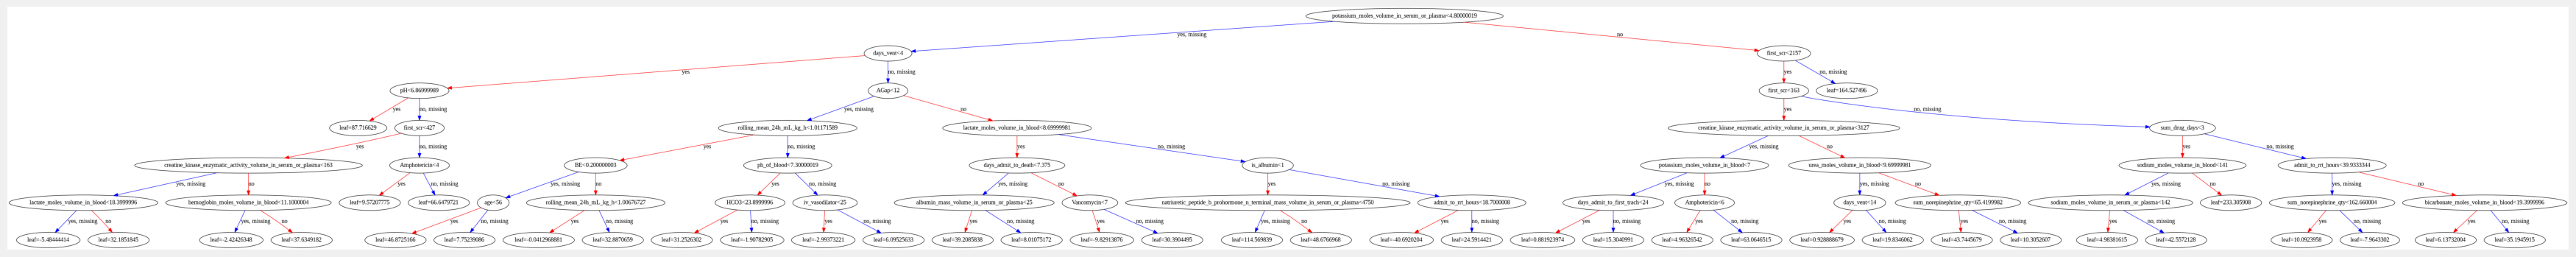

In [703]:

fig, ax = plt.subplots(figsize=(40, 40))
xg.plot_tree(grid.best_estimator_, num_trees=4, ax=ax)
plt.show()



In [698]:
xgb_r = xg.XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None, nthread=1,
             num_parallel_tree=None)

In [699]:

# Fitting the model
xgb_r.fit(x_train, y_train)
# Model Performance on the test data
xgb_perf_test = model_performance_regression(xgb_r, x_test, y_test)
xgb_perf_test


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,54.77461,29.777727,0.705283,0.68454,20.656014


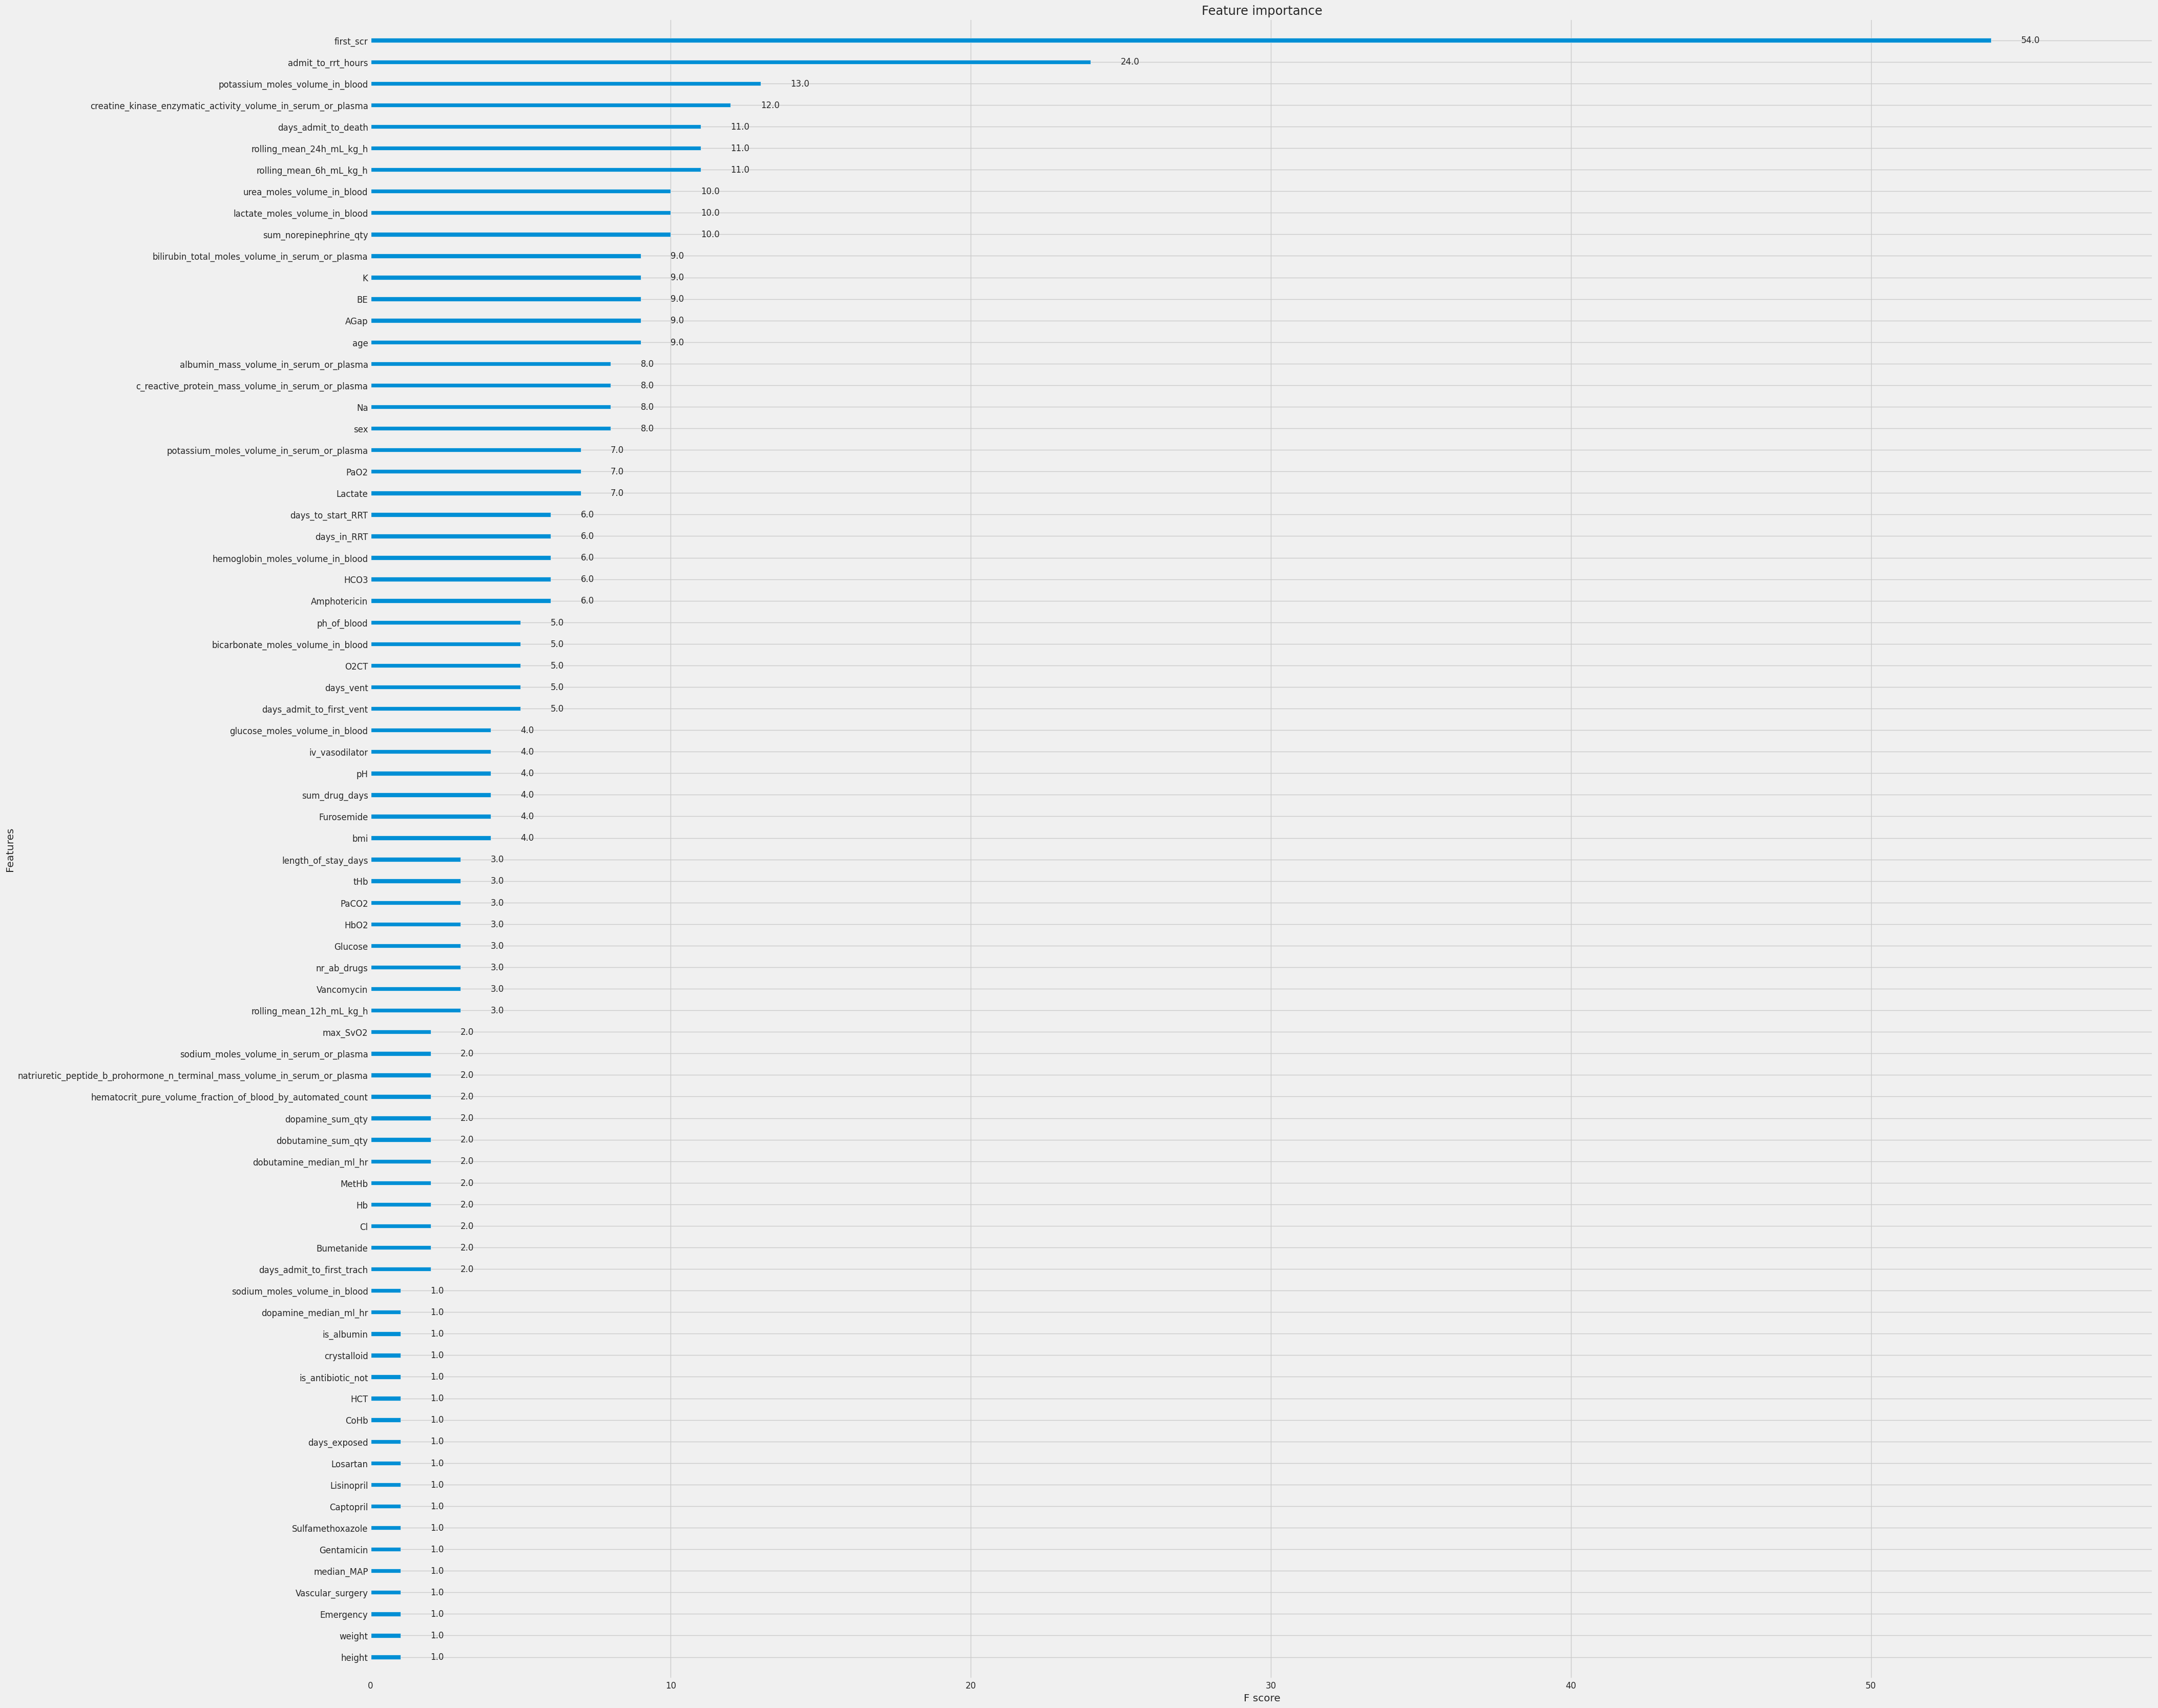

In [700]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(40,40))
plot_importance(xgb_r, ax=ax)
plt.show();

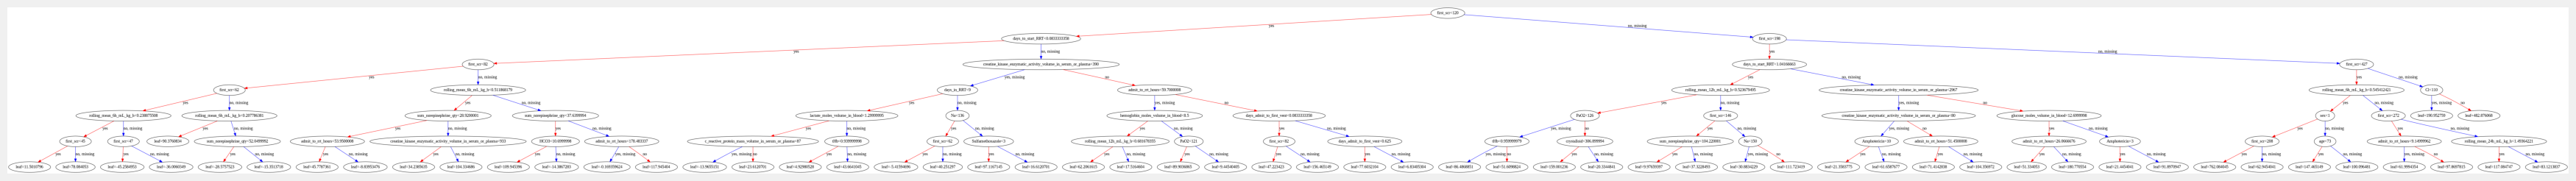

In [701]:
fig, ax = plt.subplots(figsize=(40, 40))
xg.plot_tree(xgb_r, ax=ax, max_depth=4)
plt.show()
